In [1]:
%%capture
# dry_run = False
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

In [2]:
import csv
import gc
import os
from glob import glob

import cv2
import kornia
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.feature import *

# ***Model***

In [3]:
device = torch.device("cuda")
matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(
    torch.load("../input/kornia-loftr/loftr_outdoor.ckpt")["state_dict"]
)
matcher = matcher.to(device).eval()

## ***Utils***

In [4]:
src = "/kaggle/input/image-matching-challenge-2022/"

test_samples = []
with open(f"{src}/test.csv") as f:
    reader = csv.reader(f, delimiter=",")
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    """Convenience function to write CSV files."""

    return " ".join([f"{v:.{num_digits}e}" for v in M.flatten()])


def load_torch_image(fname, device):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1])
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, False).float() / 255.0
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

# ***Parametric Study***

|Base|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |||
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|**0.723** |0.726|0.726|0.726|0.726|0.726|0.726|0.726|0.726|0.726|0.725|0.725|0.725|0.725|0.725|0.725|0.723|0.723|0.723|0.723|0.722|0.697|0.653|0.608|
|**0.25**|0.19|0.18|0.17|0.195|0.19|0.185|0.18|0.175|0.17|0.18|0.15|0.15|0.018|0.015|0.01|0.2|0.2|0.1|0.05|0.5|1|2|3|
|**0.9999**|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|0.9999|
|**100000**|300000|300000|300000|250000|250000|250000|250000|250000|250000|200000|300000|250000|200000|200000|200000|150000|250000|150000|150000|200000|200000|200000|200000|


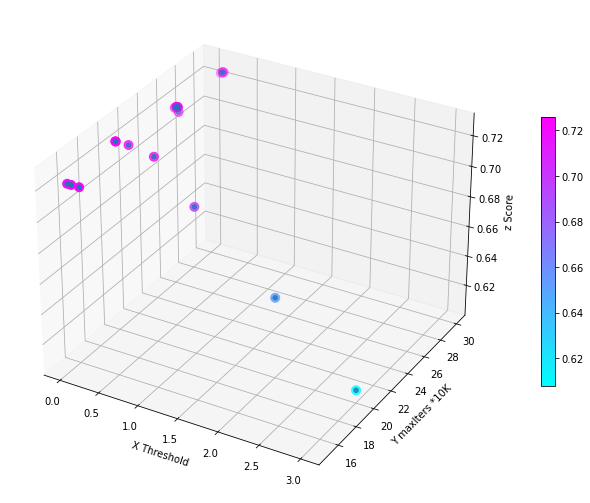

In [5]:
x = [
    0.18,
    0.19,
    0.17,
    0.195,
    0.19,
    0.185,
    0.18,
    0.175,
    0.17,
    0.18,
    0.15,
    0.15,
    0.018,
    0.015,
    0.01,
    0.2,
    0.2,
    0.1,
    0.05,
    0.5,
    1,
    2,
    3,
]
y = [
    30,
    30,
    30,
    25,
    25,
    25,
    25,
    25,
    25,
    20,
    30,
    25,
    20,
    20,
    20,
    15,
    25,
    15,
    15,
    20,
    20,
    20,
    20,
]
z = [
    0.726,
    0.726,
    0.726,
    0.726,
    0.726,
    0.726,
    0.726,
    0.726,
    0.726,
    0.725,
    0.725,
    0.725,
    0.725,
    0.725,
    0.725,
    0.723,
    0.723,
    0.723,
    0.723,
    0.722,
    0.697,
    0.653,
    0.608,
]

# Creating figure
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection="3d")
color_map = plt.get_cmap("cool")
scatter_plot = ax.scatter3D(x, y, z, c=z, s=80, cmap=color_map)


ax.scatter(x, y, z, marker="o", cmap=color_map)
# Creating Colorbar
plt.colorbar(scatter_plot, shrink=0.55)

ax.set_xlabel("X Threshold ")
ax.set_ylabel("Y maxIters *10K")
ax.set_zlabel("z Score")

plt.show()

# Takeaway

- In this experiment, with our dataset, the pretrained LoFTR outdoors model seems to reach a plateau at 0.726.
- OpenCV indicate that the treshold RANSAC Parameter should be set to 1-3. In our case, going significantly lower allows for a better scores.
- The 0.726 scoring plateau seems to be around maxIters above 200000 and Treshold below 0.20 with a confidence parameter at 0.9999.

# ***Inference***

torch.Size([1, 3, 840, 472])


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


Running time:  6.523724794387817  s
torch.Size([1, 3, 840, 472])
Running time:  0.6322829723358154  s
torch.Size([1, 3, 840, 472])
Running time:  1.340986967086792  s


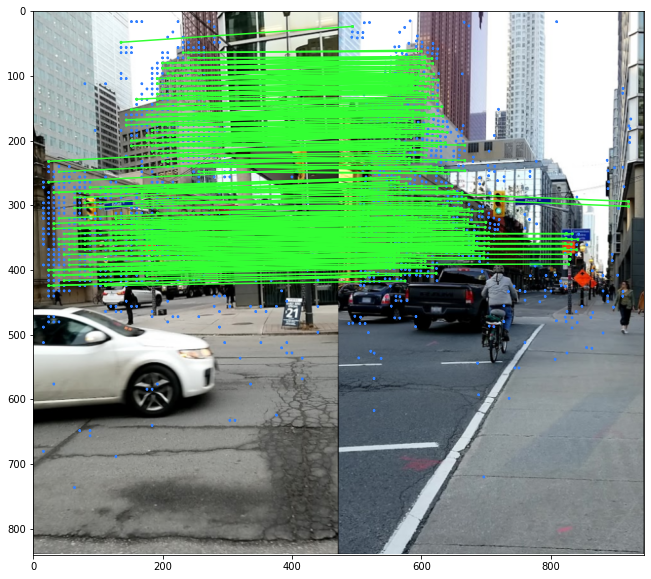

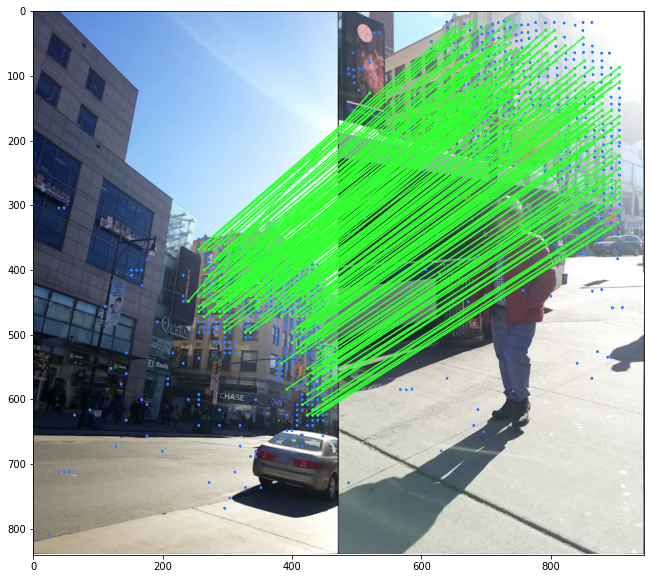

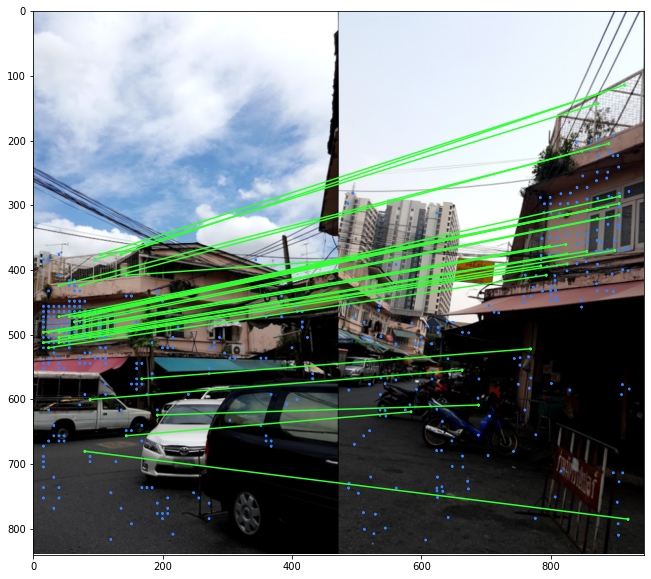

In [6]:
F_dict = {}
import time

for i, row in enumerate(test_samples):
    sample_id, batch_id, image_1_id, image_2_id = row
    # Load the images.
    st = time.time()
    image_1 = load_torch_image(f"{src}/test_images/{batch_id}/{image_1_id}.png", device)
    image_2 = load_torch_image(f"{src}/test_images/{batch_id}/{image_2_id}.png", device)
    print(image_1.shape)
    input_dict = {
        "image0": K.color.rgb_to_grayscale(image_1),
        "image1": K.color.rgb_to_grayscale(image_2),
    }

    with torch.no_grad():
        correspondences = matcher(input_dict)

    mkpts0 = correspondences["keypoints0"].cpu().numpy()
    mkpts1 = correspondences["keypoints1"].cpu().numpy()

    if len(mkpts0) > 7:
        F, inliers = cv2.findFundamentalMat(
            mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.200, 0.9999, 250000
        )
        inliers = inliers > 0
        assert F.shape == (3, 3), "Malformed F?"
        F_dict[sample_id] = F
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
    gc.collect()
    nd = time.time()
    if i < 3:
        print("Running time: ", nd - st, " s")
        draw_LAF_matches(
            KF.laf_from_center_scale_ori(
                torch.from_numpy(mkpts0).view(1, -1, 2),
                torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
                torch.ones(mkpts0.shape[0]).view(1, -1, 1),
            ),
            KF.laf_from_center_scale_ori(
                torch.from_numpy(mkpts1).view(1, -1, 2),
                torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
                torch.ones(mkpts1.shape[0]).view(1, -1, 1),
            ),
            torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
            K.tensor_to_image(image_1),
            K.tensor_to_image(image_2),
            inliers,
            draw_dict={
                "inlier_color": (0.2, 1, 0.2),
                "tentative_color": None,
                "feature_color": (0.2, 0.5, 1),
                "vertical": False,
            },
        )

with open("submission.csv", "w") as f:
    f.write("sample_id,fundamental_matrix\n")
    for sample_id, F in F_dict.items():
        f.write(f"{sample_id},{FlattenMatrix(F)}\n")

<center>
    <h2 style="color: #022047"> Thanks for reading 🤗  </h2>
</center>